# 04. XGBoost (Dos Clases)

Implementar XGBoost para el problema de dos clases.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import xgboost as xgb
from sklearn import metrics
import graphviz
import joblib

## Read data

In [ ]:
base_path = "../data/processed/definitive-two-classes/"

train = pd.read_csv(base_path + "train.csv")
test = pd.read_csv(base_path + "test.csv")
real = pd.read_csv(base_path + "test.csv", dtype = {'FAM_Sample_info_id': str, 'VIC_Sample_info_id': str})

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed/definitive-two-classes/train.csv'

In [ ]:
# Declare feature and label columns
feature_columns = ["k1", "k2", "ValueLog10"]
label_columns = ["True_positive"]

In [ ]:
# Select feature and label columns
X_train = train[feature_columns]
y_train = train[label_columns]

X_test = test[feature_columns]
y_test = test[label_columns]

X_real = real[feature_columns]
y_real = real[label_columns]

## Train XGBoost

In [ ]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

### Feature Importance

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

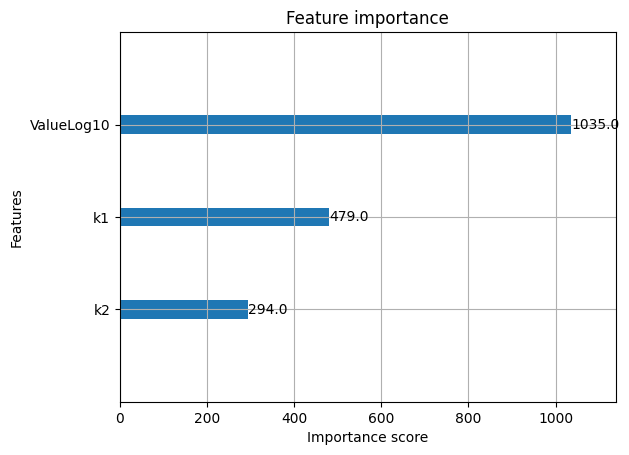

In [ ]:
xgb.plot_importance(model)

In [ ]:
model_importance = pd.DataFrame(list(model.get_booster().get_fscore().items()),
columns = ['feature','importance']).sort_values('importance', ascending = False)
print('', model_importance)

       feature  importance
2  ValueLog10      1035.0
0          k1       479.0
1          k2       294.0


### Árbol de Ejemplo

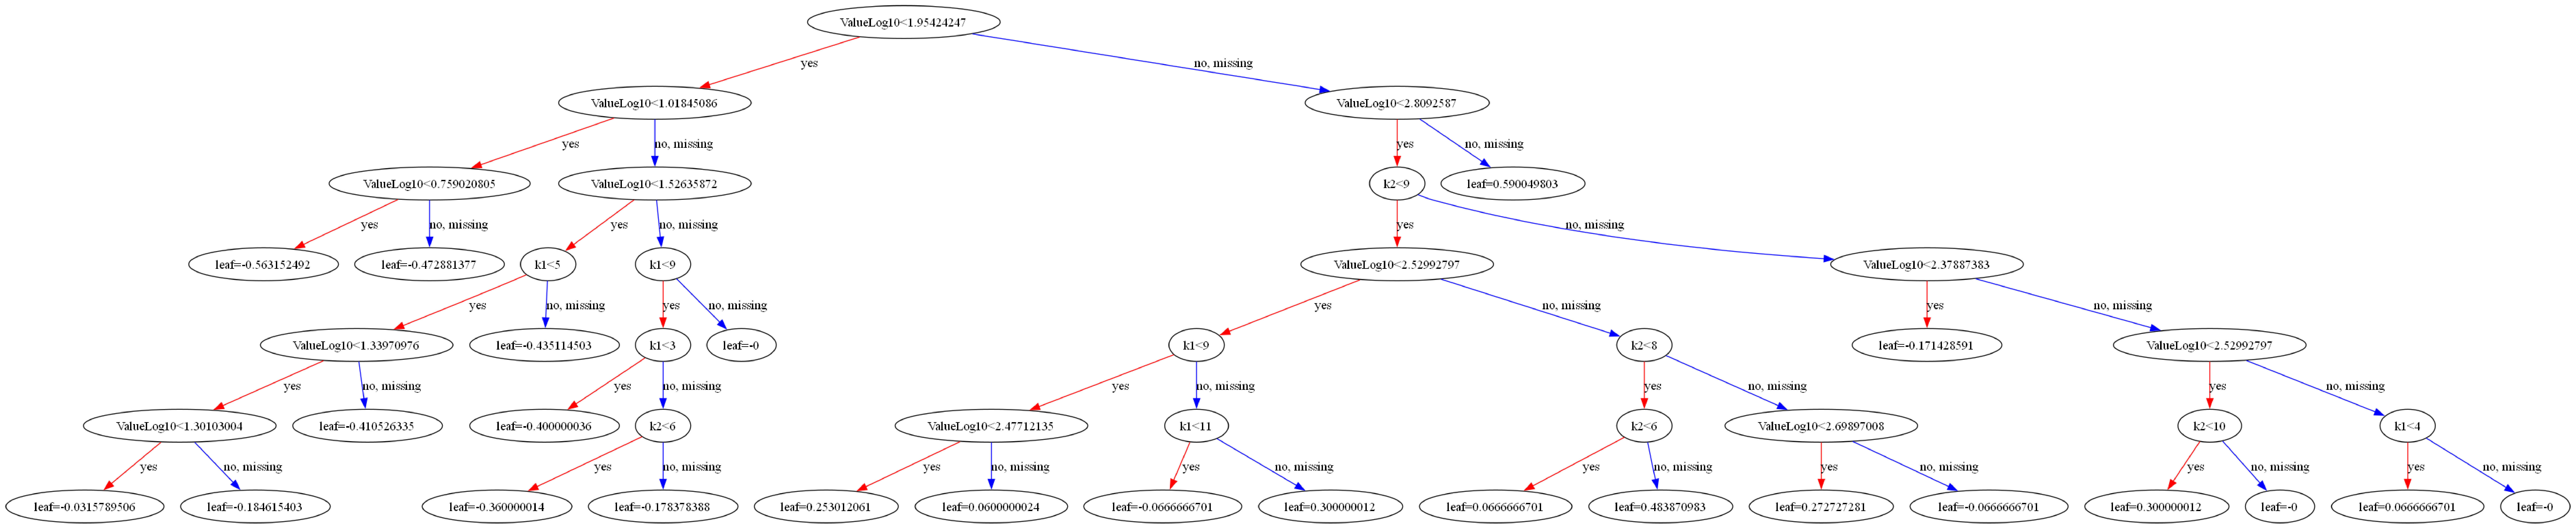

In [ ]:
xgb.plot_tree(model, tree_idx = 0)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(150, 100)

### Mostrar una Proyección de la Función Aprendida por el Árbol

In [ ]:
index_to_study = 2
proj_range = list(range(0, 20000))

df_range = pd.DataFrame(np.stack((X_train.iloc[index_to_study, :].values, ) * len(proj_range), axis = 0),
                        columns = X_train.columns)
df_range["ValueLog10"] = proj_range

Text(0, 0.5, 'Predicción')

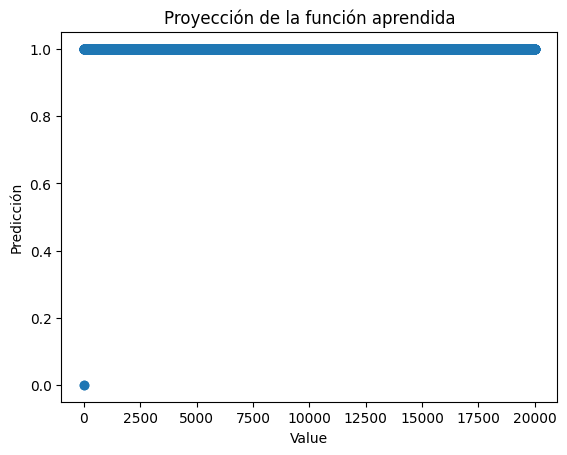

In [ ]:
aux_out = model.predict(df_range)
plt.scatter(proj_range, aux_out)

plt.title("Proyección de la función aprendida")
plt.xlabel("Value")
plt.ylabel("Predicción")


### Evaluar la Capacidad de Aprendizaje

In [ ]:
y_train_pred = model.predict(X_train)

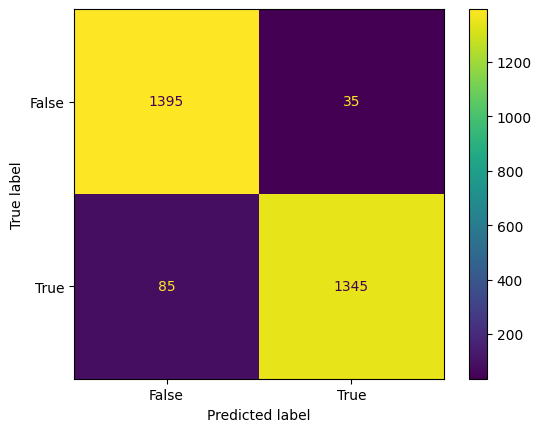

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_train, y_train_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Paternidad", "NO Paternidad"])

cm_display.plot()
plt.show()

In [ ]:
print(metrics.classification_report(y_train, y_train_pred, target_names = ["Paternidad", "NO Paternidad"]))

               precision    recall  f1-score   support

NO Parentesco       0.94      0.98      0.96      1430
   Parentesco       0.97      0.94      0.96      1430

     accuracy                           0.96      2860
    macro avg       0.96      0.96      0.96      2860
 weighted avg       0.96      0.96      0.96      2860



## Predict with XGBoost

In [ ]:
y_pred = model.predict(X_test)

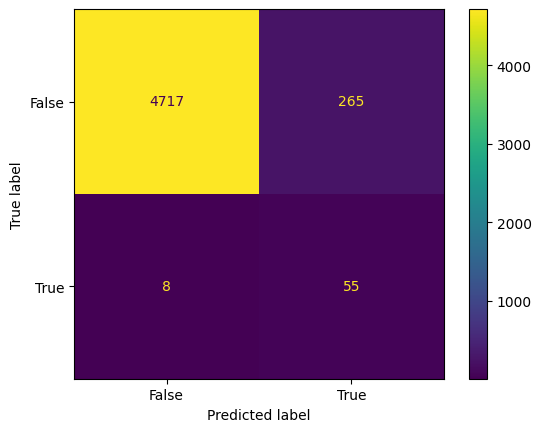

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Paternidad", "NO Paternidad"])

cm_display.plot()
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names = ["Paternidad", "NO Paternidad"]))

               precision    recall  f1-score   support

NO Parentesco       1.00      0.95      0.97      4982
   Parentesco       0.17      0.87      0.29        63

     accuracy                           0.95      5045
    macro avg       0.59      0.91      0.63      5045
 weighted avg       0.99      0.95      0.96      5045



### Predict With Real Data

In [ ]:
y_pred = model.predict(X_real)

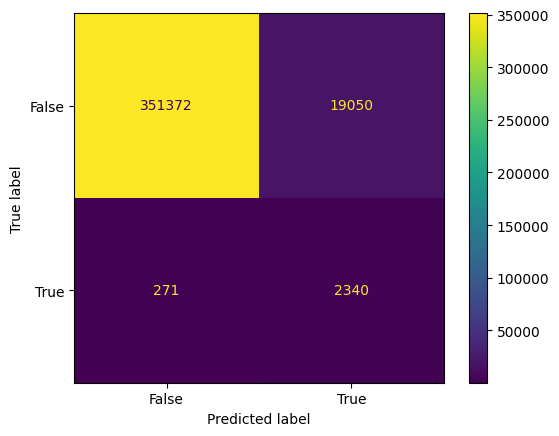

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_real, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Paternidad", "NO Paternidad"])

cm_display.plot()
plt.show()

In [ ]:
print(metrics.classification_report(y_real, y_pred, target_names = ["Paternidad", "NO Paternidad"]))

               precision    recall  f1-score   support

NO Parentesco       1.00      0.95      0.97    370422
   Parentesco       0.11      0.90      0.19      2611

     accuracy                           0.95    373033
    macro avg       0.55      0.92      0.58    373033
 weighted avg       0.99      0.95      0.97    373033



### Save Model

In [ ]:
filename = '../models/xgboost-twoclass-v00.joblib'
joblib.dump(model, filename)

## Hyperparameter Tuning with Grid Search

In [26]:
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [27]:
def timer(start_time = None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [28]:
params = {
        'min_child_weight': [1, 3, 5],
        'max_depth': [2, 5, 10],
        'n_estimators': [100, 250, 500],
        'booster': ["gbtree", "gblinear", "dart"],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'colsample_bytree': [0.6, 0.8, 1.0]
        }

In [29]:
model = xgb.XGBClassifier(learning_rate = 0.005,
                          silent = True,
                          nthread = -1)

In [ ]:
folds = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 31)

grid_search = GridSearchCV(model, param_grid = params, scoring='roc_auc', n_jobs=4, cv = skf.split(X_train, y_train), verbose=3)

# Begin grid search
start_time = timer(None)
grid_search.fit(X_train, y_train)
timer(start_time)

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits


In [ ]:
print('\n Best normalized gini score for %d-fold search.' % (folds))
print(grid_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
results.to_csv('xgb-grid-search-results-01.csv', index=False)


 Best normalized gini score for 5-fold search.
0.9783068270320254

 Best hyperparameters:
{'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 500}


### Predict with the best model

In [ ]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

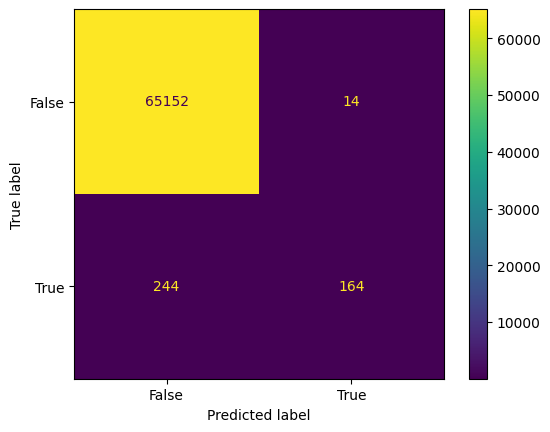

In [ ]:
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = ["Paternidad", "NO Paternidad"])

cm_display.plot()
plt.show()

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names = ["Paternidad", "NO Paternidad"]))

               precision    recall  f1-score   support

NO Parentesco       1.00      1.00      1.00     65166
   Parentesco       0.92      0.40      0.56       408

     accuracy                           1.00     65574
    macro avg       0.96      0.70      0.78     65574
 weighted avg       1.00      1.00      1.00     65574



### Save Model

In [ ]:
filename = '../models/xgboost-twoclass-v01.joblib'
joblib.dump(model, filename)